In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-Learn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

# TensorFlow / Keras 
from tensorflow.keras.models import Model, Sequential,save_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Basic Info

In [34]:
# 1. Load the Data
df = pd.read_csv('creditcard.csv')

# 2. Look at the first 5 rows
print("the first 5 rows:\n",df.head())

# 3. Check data types and missing values
print("\ndata info:\n")
df.info()

# 4. Get statistical summary (mean, max, min)
print("\nstatistical summary:\n",df.describe())

the first 5 rows:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26  

The Imbalance Check

Normal share: 99.83%
Fraud share: 0.17%


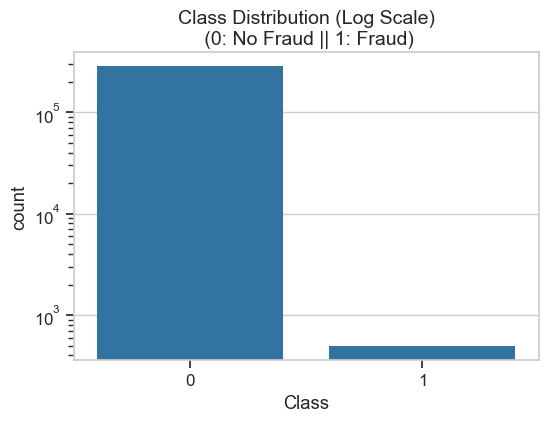

In [35]:

# Count the number of fraud vs non-fraud
classes = df['Class'].value_counts()
normal_share = classes[0] / df['Class'].count() * 100
fraud_share = classes[1] / df['Class'].count() * 100

print(f"Normal share: {normal_share:.2f}%")
print(f"Fraud share: {fraud_share:.2f}%")

# Visualize it with a Log Scale
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.yscale('log') # This makes the small bar visible
plt.title('Class Distribution (Log Scale)\n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

Analyze "Time" and "Amount"

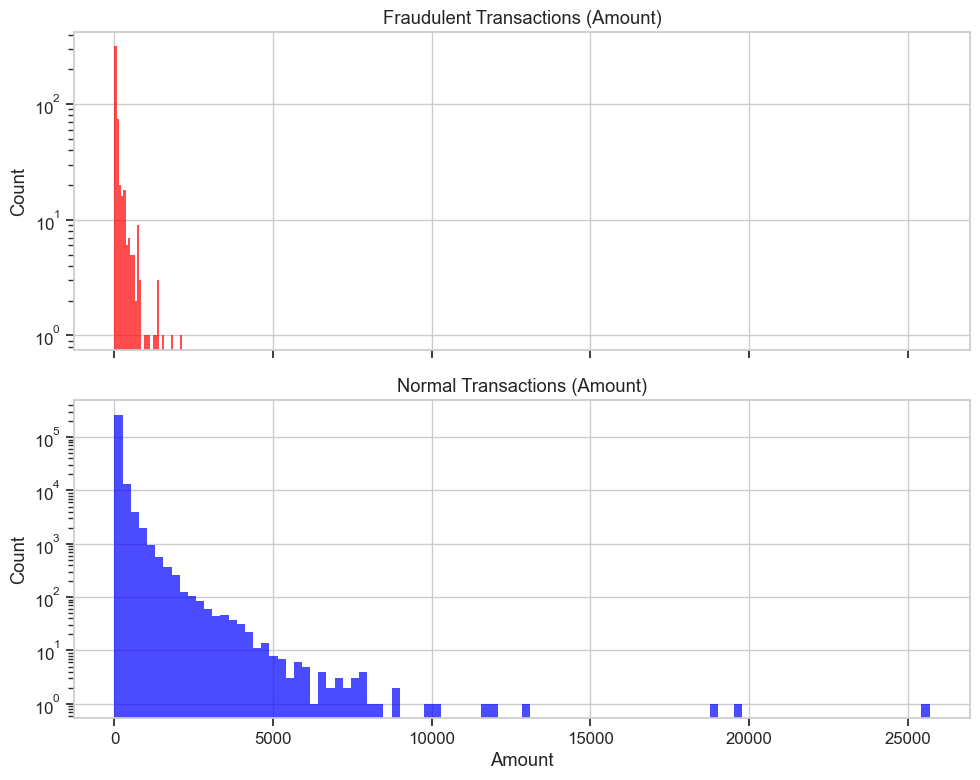

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# 1. Fraud Plot
ax1.hist(df[df['Class'] == 1].Amount, bins=30, color='red', alpha=0.7)
ax1.set_title('Fraudulent Transactions (Amount)')
ax1.set_ylabel('Count')
ax1.set_yscale('log')  # <---  Reveals hidden details

# 2. Normal Plot
ax2.hist(df[df['Class'] == 0].Amount, bins=100, color='blue', alpha=0.7)
ax2.set_title('Normal Transactions (Amount)')
ax2.set_ylabel('Count')
ax2.set_yscale('log') 

plt.xlabel('Amount')
plt.tight_layout()
plt.show()

Correlation Matrix (Heatmap)

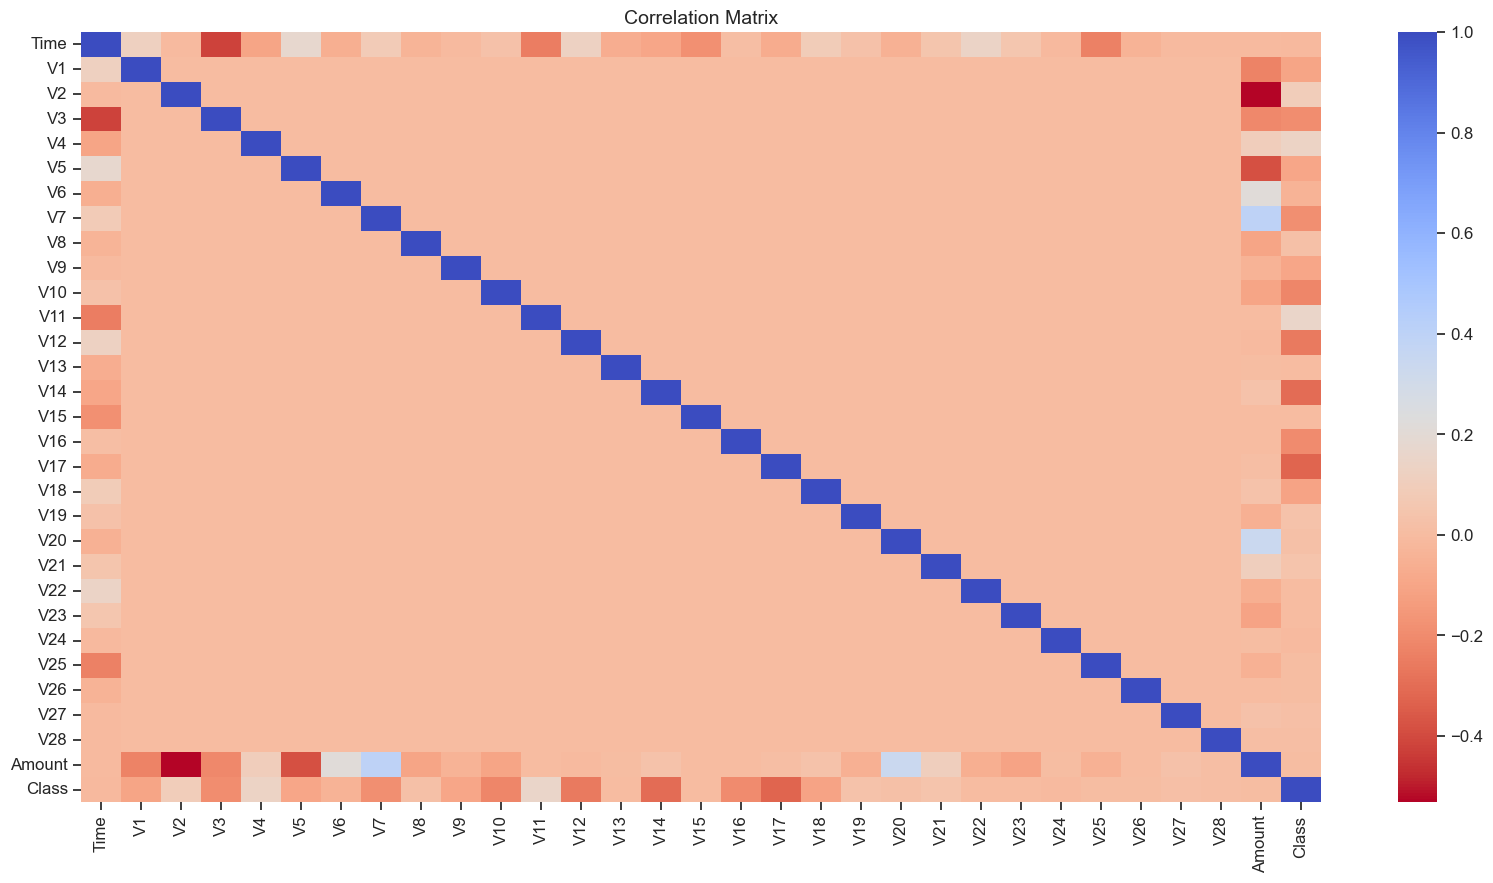

In [37]:
plt.figure(figsize=(20,10))
# Calculate correlation
corr = df.corr()
# Plot heatmap
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title("Correlation Matrix", fontsize=14)
plt.show()

Data Prep

In [38]:
# 1. SEPARATE FEATURES & TARGET 
X = df.drop(['Class'], axis=1)
y = df['Class']

# 2. SPLIT THE DATA FIRST: This ensures the Test set remains completely unseen
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. SCALE PREVENTING LEAKAGE: We use RobustScaler because Fraud data has extreme outliers
scaler = RobustScaler() 

# Columns to scale (V1-V28 are already scaled by PCA, usually we only scale Time/Amount)
cols_to_scale = ['Time', 'Amount']

# FIT the scaler on TRAIN data only, then TRANSFORM both
X_train_all.loc[:, cols_to_scale] = scaler.fit_transform(X_train_all[cols_to_scale])
X_test.loc[:, cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# 4. FILTER TRAINING DATA (For Autoencoder): We only want to train on Normal data (Class == 0)
train_indices = y_train_all[y_train_all == 0].index
X_train_normal = X_train_all.loc[train_indices]

# Convert to arrays for Keras
X_train_normal = X_train_normal.values
X_test = X_test.values

print(f"Total Train Data: {X_train_all.shape}")
print(f"Normal Train Data (used for model): {X_train_normal.shape}")
print(f"Test Data (Mixed Normal + Fraud): {X_test.shape}")
print("Ready for the Autoencoder!")

Total Train Data: (227845, 30)
Normal Train Data (used for model): (227451, 30)
Test Data (Mixed Normal + Fraud): (56962, 30)
Ready for the Autoencoder!


Build the Brain (The Autoencoder)

In [39]:

# 1. Define Architecture 
input_dim = X_train_normal.shape[1]
input_layer = Input(shape=(input_dim, ))

# Encoder: Compressing harder to 10 dimensions
encoder = Dense(20, activation="tanh")(input_layer)
encoder = Dense(10, activation="relu")(encoder) 

# Decoder
decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)

# Combine
autoencoder = Model(inputs=input_layer, outputs=decoder)

# 2. Compile
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 3. Define Early Stopping (Stops training if not improving for 3 epochs)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 4. Train 
print("Starting Optimized Training...")
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,               
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stop]    
)

print("Training finished!")

Starting Optimized Training...
Epoch 1/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.6014 - val_loss: 0.4158
Epoch 2/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.4024 - val_loss: 0.3501
Epoch 3/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.3556 - val_loss: 0.3237
Epoch 4/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.3289 - val_loss: 0.3016
Epoch 5/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.3089 - val_loss: 0.2941
Epoch 6/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.2944 - val_loss: 0.2952
Epoch 7/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.2841 - val_loss: 0.2850
Epoch 8/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.2775 - val_loss: 0.2657
Epoch 9/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.2668 - val_loss: 0.2658
Epoch 10/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.2630 - val_loss: 0.3122
Epoch 11/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.2594 - val_l

Test:Input (30) --> Encoder (14) --> Decoder (30) --> Output.

Making predictions...
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step

 FINAL RESULTS 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.33      0.77      0.46        98

    accuracy                           1.00     56962
   macro avg       0.67      0.88      0.73     56962
weighted avg       1.00      1.00      1.00     56962



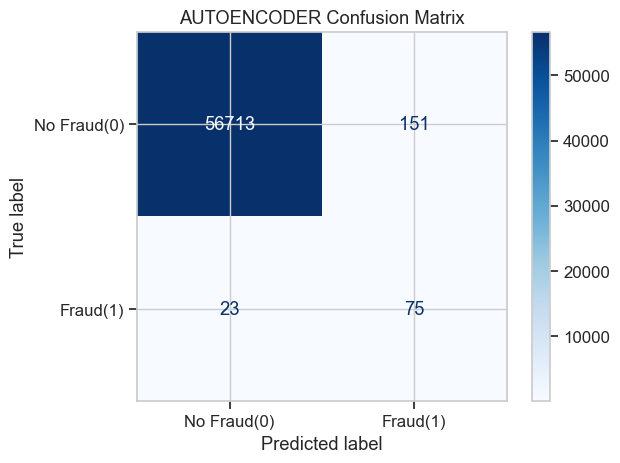

In [40]:
#  PREDICT & CALCULATE ERROR
print("Making predictions...")
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test.values})

#  DETECT FRAUD:Any error higher than 2.9 is a "Fraud Alert"
threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

print("\n FINAL RESULTS ")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Fraud(0)","Fraud(1)"])
disp.plot(cmap="Blues")
plt.title("AUTOENCODER Confusion Matrix")
plt.show()


Scatter Plot of Reconstruction Errors

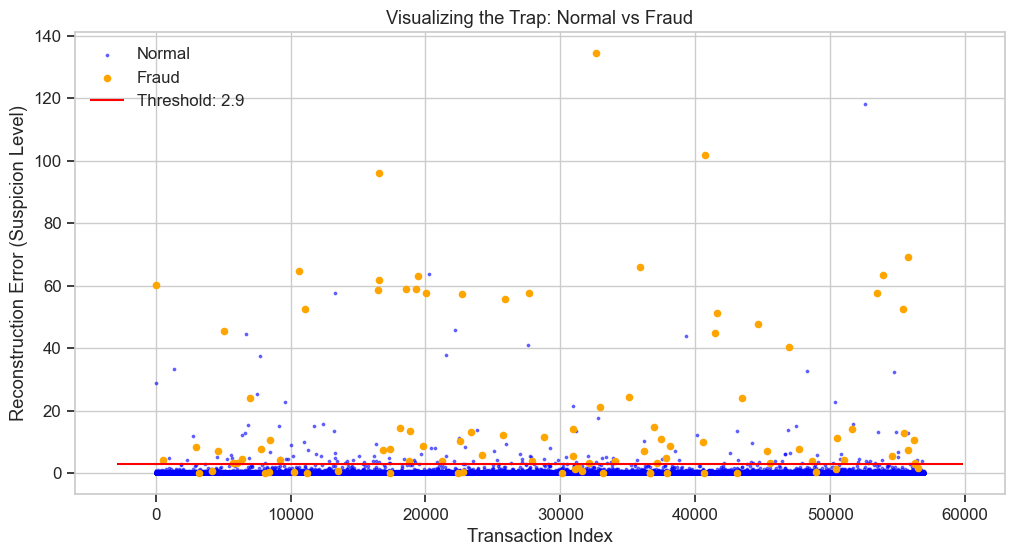

In [41]:

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Normal Transactions (Blue)
normal_df = error_df[error_df.true_class == 0]
ax.scatter(normal_df.index, normal_df.reconstruction_error, c='blue', alpha=0.5, s=3, label='Normal')

# Plot Fraud Transactions (Orange) - We make these bigger so you can see them
fraud_df = error_df[error_df.true_class == 1]
ax.scatter(fraud_df.index, fraud_df.reconstruction_error, c='orange', alpha=1.0, s=20, label='Fraud')

# Draw the Red "Threshold" Line
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="red", zorder=100, label=f'Threshold: {threshold}')

plt.title('Visualizing the Trap: Normal vs Fraud')
plt.xlabel('Transaction Index')
plt.ylabel('Reconstruction Error (Suspicion Level)')
plt.legend()
plt.show()

Prepare the "Clean" Data (Using previous Autoencoder)

In [42]:
# We wrap the "input" and the "encoder output" into a new Model:This creates a standalone machine that stops halfway through
encoder_model = Model(inputs=input_layer, outputs=encoder)
print("Encoder Model created successfully!")

X_train_encoded = encoder_model.predict(X_train_all)
X_test_encoded  = encoder_model.predict(X_test)

print(f"Original Shape: {X_train_all.shape}")
print(f"Encoded Shape:  {X_train_encoded.shape}") 

Encoder Model created successfully!
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 4s 610us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step
Original Shape: (227845, 30)
Encoded Shape:  (227845, 10)


Build the Deep Detective (The Classifier)

In [43]:

# We check the shape of X_train_encoded
actual_dim = X_train_encoded.shape[1]
print(f"The Encoder output has {actual_dim} features. Building classifier for that...")
# Calculate weights based on the training data
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_all),
    y=y_train_all
)
class_weights_dict = {0: weights[0], 1: weights[1]}
print(f"Re-calculated Class Weights: {class_weights_dict}")
# STEP 1: CALCULATE RECONSTRUCTION ERROR : Get the reconstruction for the FULL training set
reconstructions_train = autoencoder.predict(X_train_all)
mse_train = np.mean(np.power(X_train_all.values - reconstructions_train, 2), axis=1)

# Get the reconstruction for the TEST set
reconstructions_test = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - reconstructions_test, 2), axis=1)

# Reshape error to be a column vector (so we can stack it)
mse_train = np.array(mse_train).reshape(-1, 1)
mse_test = np.array(mse_test).reshape(-1, 1)
# STEP 2: COMBINE FEATURES (5 Neurons + 1 Error = 6 Features)
X_train_encoded = encoder_model.predict(X_train_all)
X_test_encoded  = encoder_model.predict(X_test)

# Stack them
X_train_enhanced = np.hstack((X_train_encoded, mse_train))
X_test_enhanced  = np.hstack((X_test_encoded, mse_test))

print(f"Old Input Shape: {X_train_encoded.shape}")
print(f"New Input Shape: {X_train_enhanced.shape} (Added Reconstruction Error)")
# STEP 3: TRAIN THE ENHANCED CLASSIFIER
input_dim_hybrid = X_train_enhanced.shape[1] # Should be 6

model_hybrid = Sequential()
model_hybrid.add(Dense(16, input_dim=input_dim_hybrid, activation='relu'))
model_hybrid.add(Dropout(0.2))
model_hybrid.add(Dense(8, activation='relu'))
model_hybrid.add(Dense(1, activation='sigmoid'))

model_hybrid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train with Class Weights
print("\nTraining Enhanced Hybrid Model...")
history = model_hybrid.fit(
    X_train_enhanced, y_train_all,  
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict, # Ensure this matches your variable name
    validation_split=0.2,
    verbose=0
)
print("Training Complete.")

The Encoder output has 10 features. Building classifier for that...
Re-calculated Class Weights: {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 5s 692us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 7s 955us/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step
Old Input Shape: (227845, 10)
New Input Shape: (227845, 11) (Added Reconstruction Error)

Training Enhanced Hybrid Model...


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Complete.


evaluation of hybrid model


 HYBRID MODEL RESULTS 
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step
 Threshold Optimization Loop 
Threshold: 0.6 | Fraud Caught: 88/98 | False Alarms: 1706 | Precision: 0.05 | Recall: 0.90
Threshold: 0.65 | Fraud Caught: 88/98 | False Alarms: 1412 | Precision: 0.06 | Recall: 0.90
Threshold: 0.75 | Fraud Caught: 88/98 | False Alarms: 922 | Precision: 0.09 | Recall: 0.90
Threshold: 0.7 | Fraud Caught: 88/98 | False Alarms: 1140 | Precision: 0.07 | Recall: 0.90
Threshold: 0.8 | Fraud Caught: 87/98 | False Alarms: 636 | Precision: 0.12 | Recall: 0.89
Threshold: 0.85 | Fraud Caught: 85/98 | False Alarms: 334 | Precision: 0.20 | Recall: 0.87
Threshold: 0.9 | Fraud Caught: 82/98 | False Alarms: 166 | Precision: 0.33 | Recall: 0.84
Threshold: 0.95 | Fraud Caught: 82/98 | False Alarms: 72 | Precision: 0.53 | Recall: 0.84
Threshold: 0.98 | Fraud Caught: 76/98 | False Alarms: 38 | Precision: 0.67 | Recall: 0.78
Threshold: 0.99 | Fraud Caught: 72/98 | False Alarms: 28 | Precision: 0.72 | Recall: 

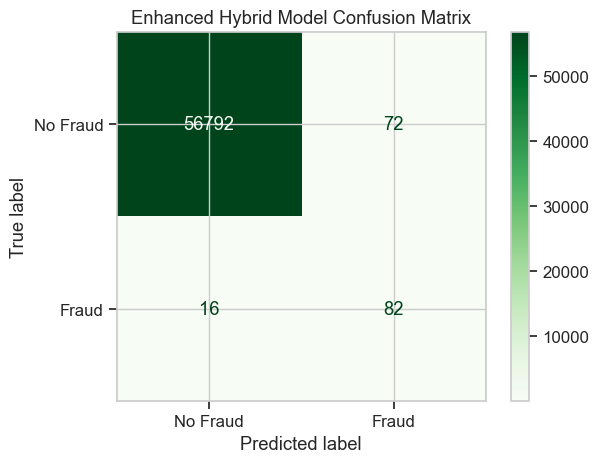

In [44]:
# 4. Evaluate
print("\n HYBRID MODEL RESULTS ")
# 1. Get the raw probabilities (0 to 1)
y_pred_prob = model_hybrid.predict(X_test_enhanced)

# 2. RUN THE LOOP TO FIND THE SWEET SPOT
print(" Threshold Optimization Loop ")
for thresh in [0.6, 0.65, 0.75, 0.7, 0.8, 0.85, 0.90, 0.95, 0.98, 0.99]:
    y_pred_loop = (y_pred_prob > thresh).astype(int)
    
    # Calculate stats for this specific threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_loop).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"Threshold: {thresh} | Fraud Caught: {tp}/98 | False Alarms: {fp} | Precision: {precision:.2f} | Recall: {recall:.2f}")
print("---------------------------------------")
# 3. VISUALIZE THE WINNER
y_pred_prob = model_hybrid.predict(X_test_enhanced)

final_thresh = 0.95
y_pred_enhanced = (y_pred_prob > final_thresh).astype(int)

print("\n ENHANCED HYBRID RESULTS ")
print(classification_report(y_test, y_pred_enhanced))

cm = confusion_matrix(y_test, y_pred_enhanced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap="Greens")
plt.title("Enhanced Hybrid Model Confusion Matrix")
plt.show()



Scatter Plot for hybrid model

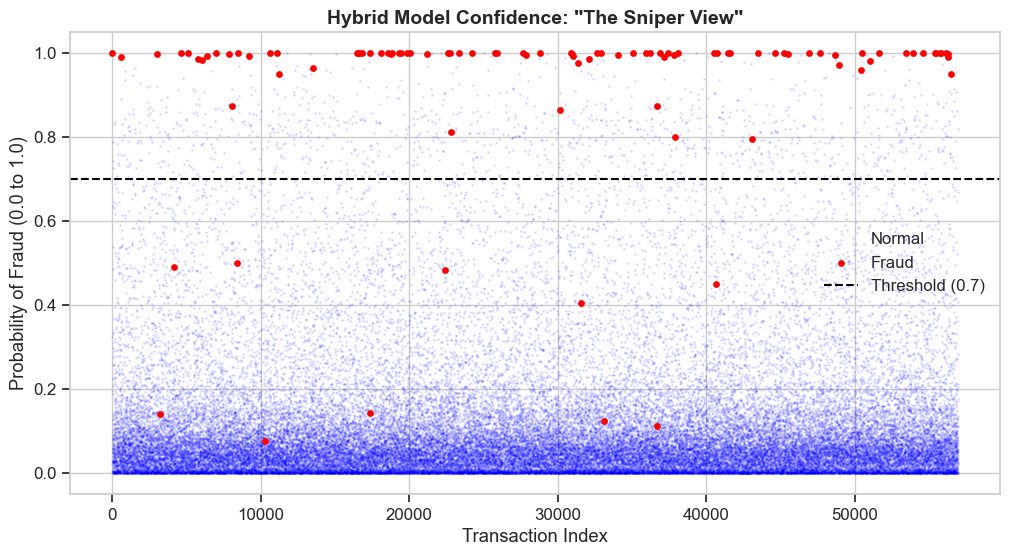

In [45]:

# Prepare the data for plotting
probs = y_pred_prob.flatten() # Convert to a simple list of numbers
# Ensure y_test is a simple array
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test

# Create a DataFrame just for the plot
plot_df = pd.DataFrame({
    'Transaction_Index': range(len(probs)), 
    'Fraud_Probability': probs, 
    'True_Class': y_test_array
})

# SCATTER PLOT CODE 
plt.figure(figsize=(12, 6))

# 1. Plot Normal Transactions (Blue): We make them small and transparent so they don't hide the fraud
plt.scatter(plot_df[plot_df.True_Class==0].Transaction_Index, 
            plot_df[plot_df.True_Class==0].Fraud_Probability, 
            c='blue', alpha=0.1, s=1, label='Normal')

# 2. Plot Fraud Transactions (Red): We make them bigger and solid red
plt.scatter(plot_df[plot_df.True_Class==1].Transaction_Index, 
            plot_df[plot_df.True_Class==1].Fraud_Probability, 
            c='red', alpha=1.0, s=15, label='Fraud')

# 3. Add the Threshold Line
plt.axhline(y=0.7, color='black', linestyle='--', label='Threshold (0.7)')

plt.title('Hybrid Model Confidence: "The Sniper View"', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Index')
plt.ylabel('Probability of Fraud (0.0 to 1.0)')
plt.legend(loc='center right')
plt.show()

In [46]:

#  Apply the  models to the FULL dataframe (df) for plotting

# 1. Prepare the full data
X_viz = df.drop(['Class'], axis=1).copy()
X_viz.loc[:, ['Time', 'Amount']] = scaler.transform(X_viz[['Time', 'Amount']])
X_viz_values = X_viz.values

#  Add 'Reconstruction_Error' to df
reconstructions = autoencoder.predict(X_viz_values)
df['Reconstruction_Error'] = np.mean(np.power(X_viz_values - reconstructions, 2), axis=1)

#  Add 'Model_Score' to df
latent_features = encoder_model.predict(X_viz_values)
hybrid_input = np.hstack((latent_features, df['Reconstruction_Error'].values.reshape(-1, 1)))
df['Model_Score'] = model_hybrid.predict(hybrid_input)

print(" 'Reconstruction_Error' and 'Model_Score' added to df.")

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 6s 707us/step
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 6s 662us/step
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 6s 643us/step
 'Reconstruction_Error' and 'Model_Score' added to df.


Plotting the Comparison 

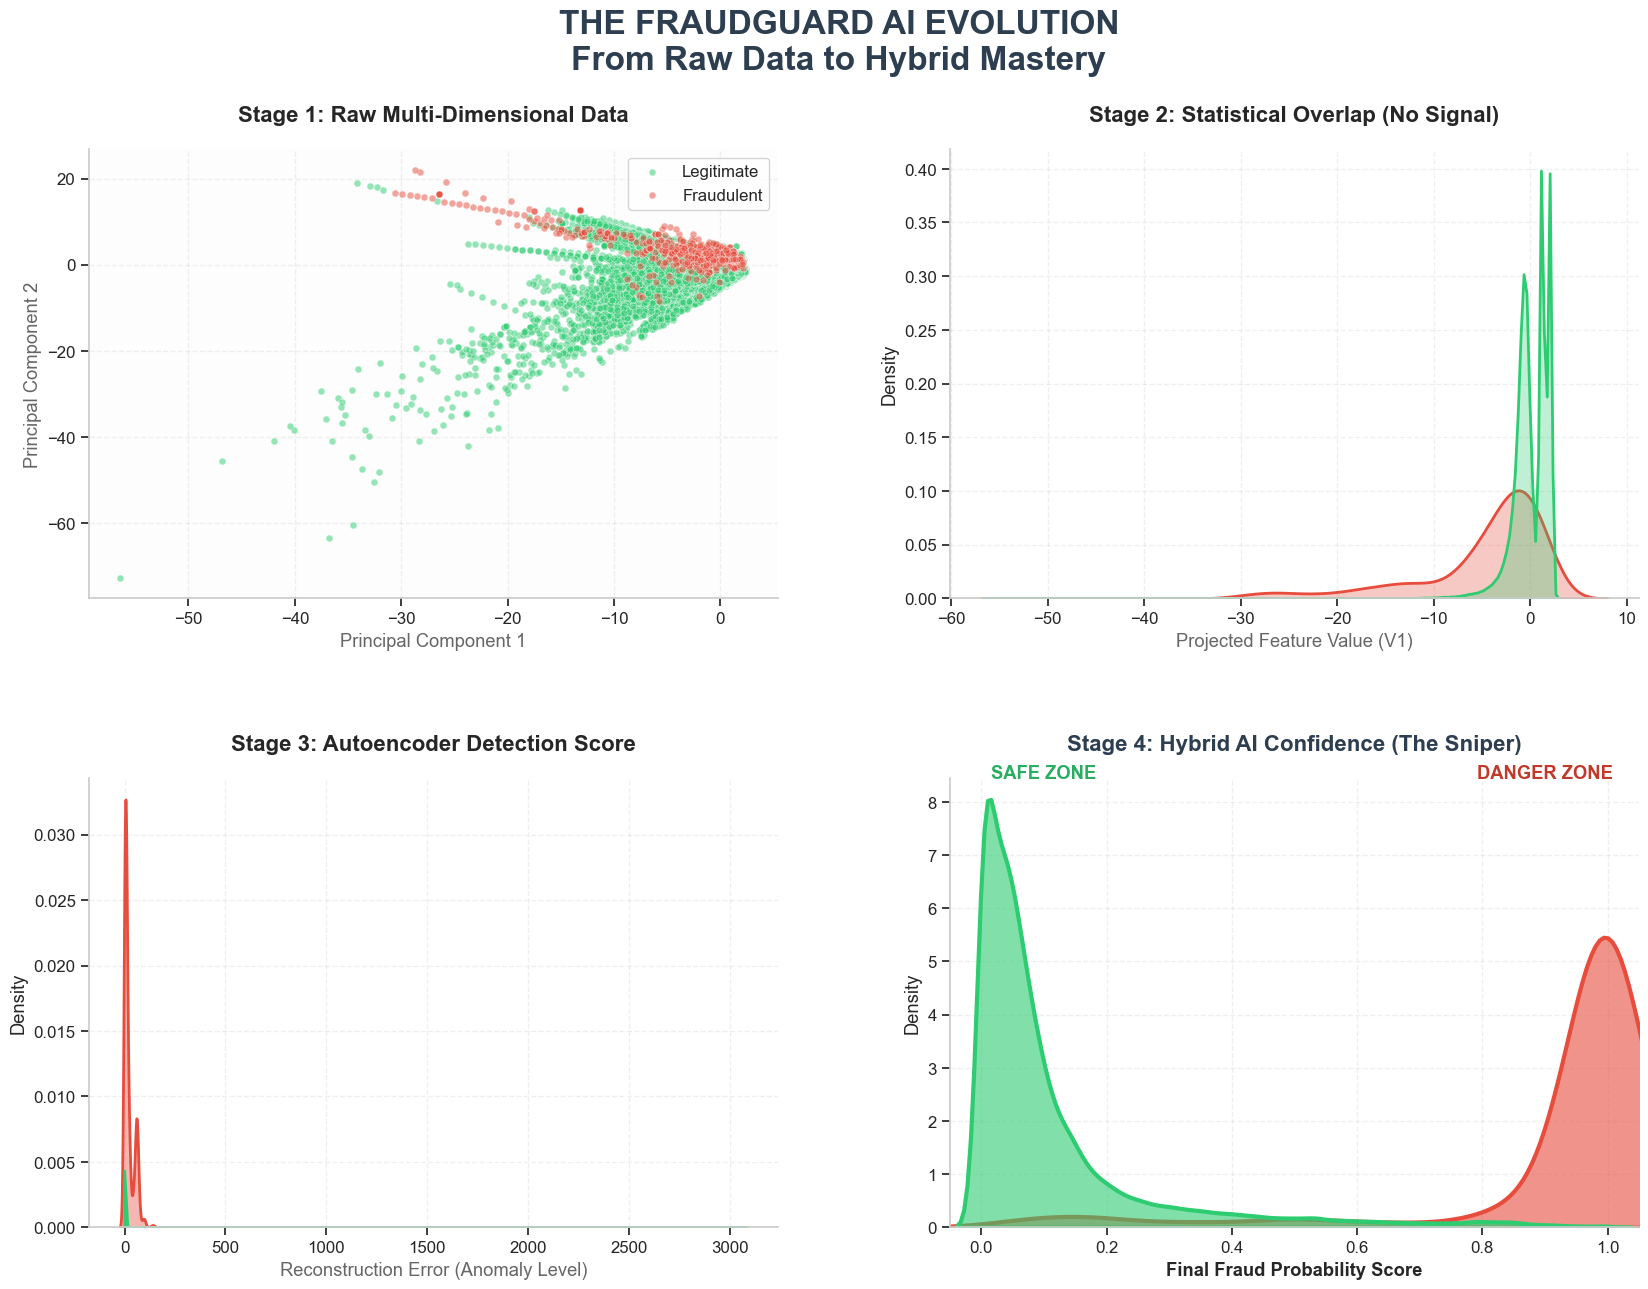

In [47]:
# 1. Setup Theme
plt.style.use('seaborn-v0_8-whitegrid') 
sns.set_context("notebook", font_scale=1.1)

# Custom Color Palette (Modern Mint & Crimson)
colors = {0: "#2ecc71", 1: "#e74c3c"}
labels = {0: 'Legitimate', 1: 'Fraudulent'}

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

#  Graph 1: Raw Data Scatter
for label in [0, 1]:
    subset = df[df['Class'] == label]
    axes[0, 0].scatter(subset['V1'], subset['V2'], c=colors[label], 
                       label=labels[label], alpha=0.5, s=25, edgecolor='white', linewidth=0.5)

axes[0, 0].set_title('Stage 1: Raw Multi-Dimensional Data', fontsize=16, fontweight='bold', pad=20)
axes[0, 0].set_facecolor('#fdfdfd')
axes[0, 0].legend(frameon=True, facecolor='white')
axes[0, 0].set_xlabel('Principal Component 1', color='#666')
axes[0, 0].set_ylabel('Principal Component 2', color='#666')

# Graph 2: Raw Data Histogram 
sns.kdeplot(data=df, x='V1', hue='Class', palette=colors, fill=True, 
            ax=axes[0, 1], alpha=0.3, linewidth=2, common_norm=False)
axes[0, 1].set_title('Stage 2: Statistical Overlap (No Signal)', fontsize=16, fontweight='bold', pad=20)
axes[0, 1].get_legend().remove()
axes[0, 1].set_xlabel('Projected Feature Value (V1)', color='#666')

# Graph 3: Autoencoder 
sns.kdeplot(data=df, x='Reconstruction_Error', hue='Class', palette=colors, fill=True, 
            ax=axes[1, 0], alpha=0.4, linewidth=2, common_norm=False)
axes[1, 0].set_title('Stage 3: Autoencoder Detection Score', fontsize=16, fontweight='bold', pad=20)
axes[1, 0].get_legend().remove()
axes[1, 0].set_xlabel('Reconstruction Error (Anomaly Level)', color='#666')
axes[1, 0].annotate('Fraud emerges', xy=(8, 0.05), xytext=(12, 0.1),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5), fontsize=12)

# Graph 4: Hybrid Model (The Final Solution)
# We use a background gradient effect for the "Safe" vs "Danger" zones
sns.kdeplot(data=df, x='Model_Score', hue='Class', palette=colors, fill=True, 
            ax=axes[1, 1], alpha=0.6, linewidth=3, common_norm=False)
axes[1, 1].set_title('Stage 4: Hybrid AI Confidence (The Sniper)', fontsize=16, fontweight='bold', color='#2c3e50', pad=20)
axes[1, 1].get_legend().remove()
axes[1, 1].set_xlim(-0.05, 1.05)
axes[1, 1].set_xlabel('Final Fraud Probability Score', fontweight='bold')

# Add "Safety" and "Danger" Zone Labels
axes[1, 1].text(0.1, 1.0, "SAFE ZONE", color='#27ae60', fontweight='bold', ha='center', transform=axes[1, 1].get_xaxis_transform())
axes[1, 1].text(0.9, 1.0, "DANGER ZONE", color='#c0392b', fontweight='bold', ha='center', transform=axes[1, 1].get_xaxis_transform())

# Final Polish: Remove top/right spines
for ax in axes.flat:
    sns.despine(ax=ax)
    ax.grid(alpha=0.3, linestyle='--')

plt.suptitle('THE FRAUDGUARD AI EVOLUTION\nFrom Raw Data to Hybrid Mastery', 
             fontsize=24, fontweight='bold', y=0.98, color='#2c3e50')

plt.savefig('enhanced_fraud_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# 1. Save the Scaler (Crucial for Time/Amount transformation: this scaler was fitted on ['Time', 'Amount'])
joblib.dump(scaler, 'scaler.pkl')

# 2. Save the "Critic" (The Autoencoder)
# This calculates the Reconstruction Error
save_model(autoencoder, 'autoencoder_model.h5')

# 3. Save the "Interpreter" (The Encoder)
# This extracts the latent features (compressed data)
save_model(encoder_model, 'encoder_model.h5')

# 4. Save the "Judge" (The Hybrid Classifier)
# This takes [Latent Features + Error] and predicts Fraud
save_model(model_hybrid, 'hybrid_model.h5')

print(" SUCCESS: All 4 system files saved successfully.")
print("   - scaler.pkl")
print("   - autoencoder_model.h5")
print("   - encoder_model.h5")
print("   - hybrid_model.h5")

 SUCCESS: All 4 system files saved successfully.
   - scaler.pkl
   - autoencoder_model.h5
   - encoder_model.h5
   - hybrid_model.h5
